## Here lets try to get some data from the alfven modes and train a few autoencoders on them to see if they capture any structure in the latent layer

In [1]:
using AlfvenDetectors
using PyPlot
using Flux
using CuArrays  # for GPU runs
using ValueHistories
using BSON: @save, @load

┌ Info: Recompiling stale cache file /home/vit/.julia/compiled/v1.1/AlfvenDetectors/VqnlF.ji for AlfvenDetectors [5e555b46-3391-11e9-1beb-e9498a8cd634]
└ @ Base loading.jl:1184


What we are doing is unsupervised training on columns of the magnitude squared coherence time histograms. 

### Collect the data

Use shot #10370 and #11960 and several coil couples. Select only some timeslices, normalize data

In [2]:
host = gethostname()
if occursin("vit", host)
    datapath = "/home/vit/vyzkum/alfven/cdb_data/original_data/"
else
    datapath = "/home/skvara/work/alfven/cdb_data/original_data/"
end

"/home/vit/vyzkum/alfven/cdb_data/original_data/"

In [3]:
function get_msc_array(datapath, shot, coil, timelim = [1.0, 1.25])
    _data = AlfvenDetectors.BaseAlfvenData(joinpath(datapath,"$(shot).h5"), [coil])
    tinds = timelim[1] .<= _data.t .<= timelim[2]
    return _data.msc[coil][:,tinds], _data.t[tinds], _data.f 
end

get_msc_array (generic function with 2 methods)

In [4]:
msc, t, f = get_msc_array(datapath, 11096, 5)

(Float32[0.964338 0.783493 … 0.845411 0.697163; 0.945307 0.795562 … 0.817875 0.79142; … ; 0.25821 0.446332 … 0.021653 0.260047; 0.263058 0.396589 … 0.0719174 0.388655], Float32[1.00244, 1.00525, 1.00806, 1.01087, 1.01369, 1.0165, 1.01931, 1.02213, 1.02494, 1.02775  …  1.22462, 1.22744, 1.23025, 1.23306, 1.23588, 1.23869, 1.2415, 1.24431, 1.24713, 1.24994], Float32[0.0, 1953.13, 3906.25, 5859.38, 7812.5, 9765.63, 11718.8, 13671.9, 15625.0, 17578.1  …  9.82422e5, 984375.0, 9.86328e5, 9.88281e5, 9.90234e5, 9.92188e5, 9.94141e5, 9.96094e5, 9.98047e5, 1.0e6])

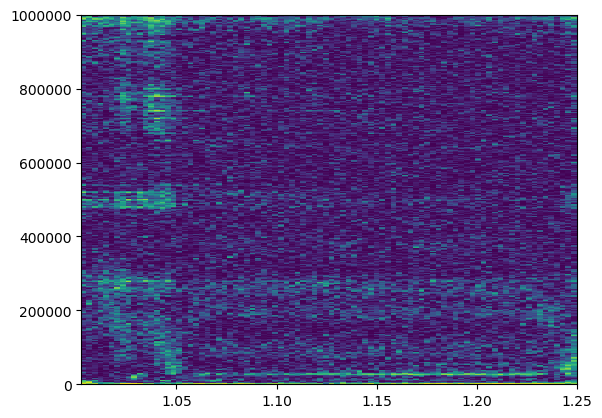

PyObject <matplotlib.collections.QuadMesh object at 0x7fe4ebad5780>

In [5]:
pcolormesh(t,f,msc)

In [6]:
function collect_msc(datapath, shot, coils)
    datalist = map(x-> get_msc_array(datapath, shot, x), coils)
    return hcat([x[1] for x in datalist]...), datalist[1][3]
end

collect_msc (generic function with 1 method)

In [7]:
shots_coils = [
#    [10370, [12, 15, 17, 20]],
    [10370, [12, 20]],
#    [11096, [11, 8, 17, 20]]
    [11096, [11, 8, 20]]
]
datalist = map(x->collect_msc(datapath, x[1], x[2]), shots_coils)
data, f = hcat([x[1] for x in datalist]...), datalist[1][2]

(Float32[0.918668 0.881605 … 0.908824 0.920963; 0.914609 0.879044 … 0.875875 0.849385; … ; 0.00910574 0.328996 … 0.0584963 0.0771319; 0.0011798 0.310406 … 0.192278 0.0363167], Float32[0.0, 1953.13, 3906.25, 5859.38, 7812.5, 9765.63, 11718.8, 13671.9, 15625.0, 17578.1  …  9.82422e5, 984375.0, 9.86328e5, 9.88281e5, 9.90234e5, 9.92188e5, 9.94141e5, 9.96094e5, 9.98047e5, 1.0e6])

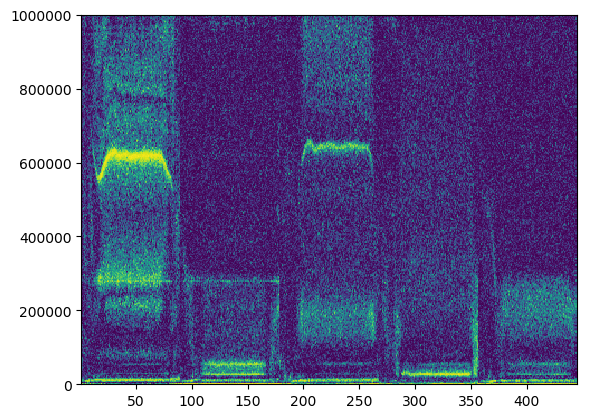

PyObject <matplotlib.collections.QuadMesh object at 0x7fe4d0065198>

In [8]:
pcolormesh(1:size(data,2), f, data)

### Now that we have the data, construct a VAE

Larger dimension of middle layer is beneficial, but improvement from 10 to 20 is much alrger than from 20 to 200.

Reconstruction works even with zdim = 2 although there are some artifacts.

In [22]:
M,N = size(data)
# fortunately data is already normalized in the interval (0,1)
zdim = 2
small_model = AlfvenDetectors.VAE([M, 20, zdim*2], [zdim, 20, M])
large_model = AlfvenDetectors.VAE([M, 200, zdim*2], [zdim, 200, M])
small_train_history = MVHistory()
large_train_history = MVHistory()
batchsize = 64
nepochs = 200
cbit = 1
# progress bars are broken in notebooks
if occursin(".jl", @__FILE__) 
    verb = true
else
    verb = false
end
# VAE specific settings
L = 1
β = 0.01

0.01

In [23]:
@info "Training small CPU model"
@time AlfvenDetectors.fit!(small_model, data, batchsize, 1;
    β = β, L = L,
    cbit = cbit, history = small_train_history, verb = verb)
@time AlfvenDetectors.fit!(small_model, data, batchsize, nepochs-1;
    β = β, L = L,
    cbit = cbit, history = small_train_history, verb = verb)

┌ Info: Training small CPU model
└ @ Main In[23]:1


  0.059453 seconds (24.65 k allocations: 32.301 MiB, 17.43% gc time)
  9.029795 seconds (4.89 M allocations: 6.276 GiB, 11.00% gc time)


Doing a fast run saves about 20% of allocations, still more than 2x as many as compared to AE. Also, setting $\beta$ to large values around 1 is detrimental to the reconstruction - however it is not detrimental to the clustering in latent space, as it still shows even when more weight is put on KL. Also, the generated samples look more realistic.

In [62]:
@info "Training large CPU model"
@time AlfvenDetectors.fit!(large_model, data, batchsize, nepochs;
    L = L, β = 1.0,
    cbit = cbit, history = large_train_history, verb = verb)

┌ Info: Training large CPU model
└ @ Main In[62]:1


 45.831982 seconds (4.96 M allocations: 11.979 GiB, 5.22% gc time)


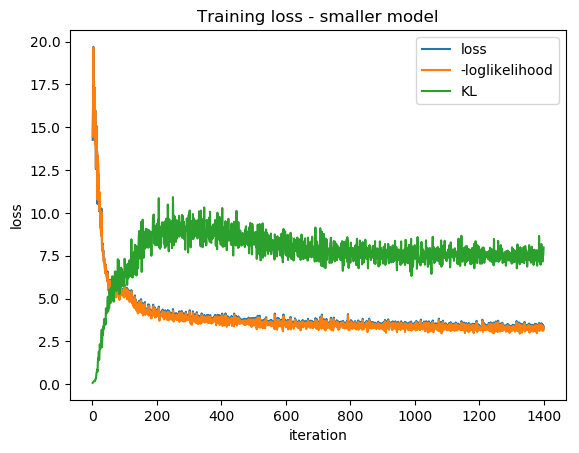

PyObject <matplotlib.legend.Legend object at 0x7fc8f817e550>

In [65]:
figure()
plot(get(small_train_history, :loss)...,label="loss")
plot(get(small_train_history, :loglikelihood)...,label="-loglikelihood")
plot(get(small_train_history, :KL)...,label="KL")
title("Training loss - smaller model")
xlabel("iteration")
ylabel("loss")
legend()

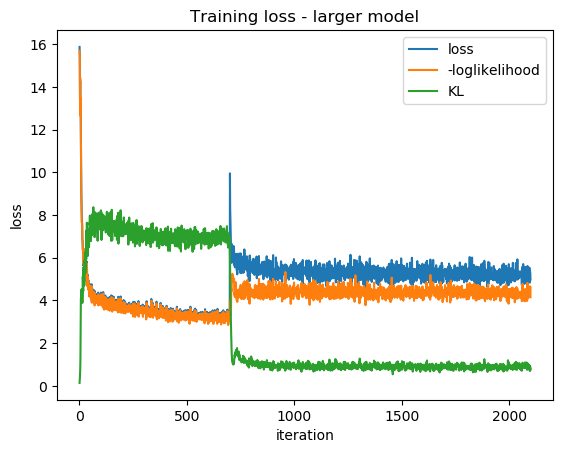

PyObject <matplotlib.legend.Legend object at 0x7fc8f80d7ef0>

In [67]:
figure()
plot(get(large_train_history, :loss)...,label="loss")
plot(get(large_train_history, :loglikelihood)...,label="-loglikelihood")
plot(get(large_train_history, :KL)...,label="KL")
title("Training loss - larger model")
xlabel("iteration")
ylabel("loss")
legend()

In [15]:
X = data;

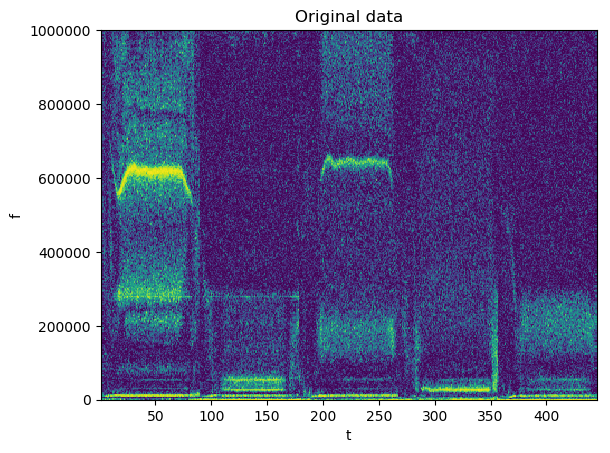

PyObject Text(24.0, 0.5, 'f')

In [27]:
figure()
pcolormesh(1:size(X,2), f, X)
title("Original data")
xlabel("t")
ylabel("f")

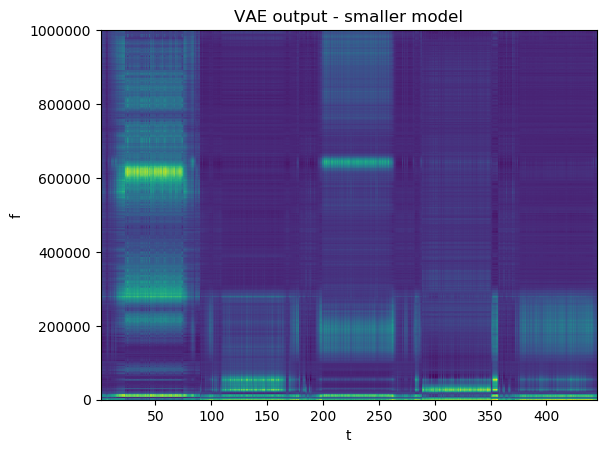

PyObject Text(24.0, 0.5, 'f')

In [46]:
figure()
sX = small_model(X).data
pcolormesh(1:size(sX,2), f, sX)
title("VAE output - smaller model")
xlabel("t")
ylabel("f")

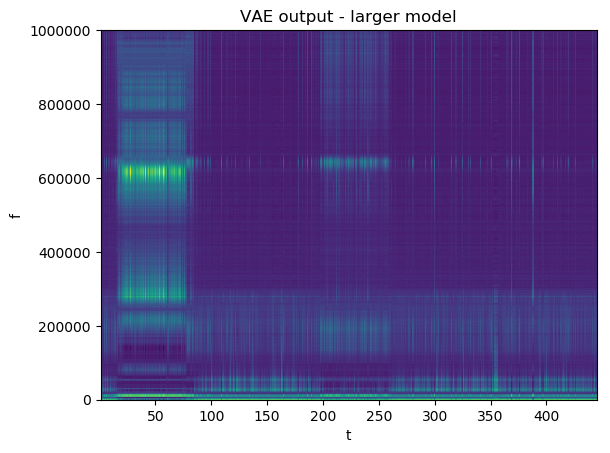

PyObject Text(24.0, 0.5, 'f')

In [68]:
figure()
lX = large_model(X).data
pcolormesh(1:size(lX,2), f, lX)
title("VAE output - larger model")
xlabel("t")
ylabel("f")

## Basic training seems to work, now test the GPU version

In [55]:
# convert to CuArrays
zdim = 2
cudata = data |> gpu
cumodel = AlfvenDetectors.VAE([M, 200, zdim*2], [zdim, 200, M]) |> gpu
cu_train_history = MVHistory()
nepochs = 200
L = 1
β = 0.01

0.01

In [33]:
@info "Training a large GPU model with less epochs in more iterations"
# clear cache

@time AlfvenDetectors.fit!(cumodel, cudata, batchsize, 1;
        L=L,β=β,
        cbit = cbit, history = cu_train_history, verb = verb)
    
for i in 1:5
    @time AlfvenDetectors.fit!(cumodel, cudata, batchsize, nepochs;
        L=L,β=β,
        cbit = cbit, history = cu_train_history, verb = verb)
    # clear cache so that the gpu memory is cleared
    GC.gc()
end

┌ Info: Training a large GPU model with less epochs in more iterations
└ @ Main In[33]:1


  0.189980 seconds (88.91 k allocations: 3.110 MiB)
 25.263309 seconds (19.19 M allocations: 645.362 MiB, 1.07% gc time)
 22.941770 seconds (19.18 M allocations: 643.860 MiB, 1.08% gc time)
 35.955770 seconds (19.18 M allocations: 644.121 MiB, 0.76% gc time)
 22.887442 seconds (19.18 M allocations: 643.842 MiB, 1.06% gc time)
 23.977201 seconds (19.18 M allocations: 643.880 MiB, 1.03% gc time)


In [21]:
@info "large CPU model(data) timing"
@time large_model(data);

  0.003944 seconds (183 allocations: 3.144 MiB)


┌ Info: large CPU model(data) timing
└ @ Main In[21]:1


In [22]:
@info "GPU model(data) timing"
@time cumodel(cudata);

  0.000600 seconds (664 allocations: 38.063 KiB)


┌ Info: GPU model(data) timing
└ @ Main In[22]:1


In case of VAE, GPU is a considerable boost to training and evaluation times.

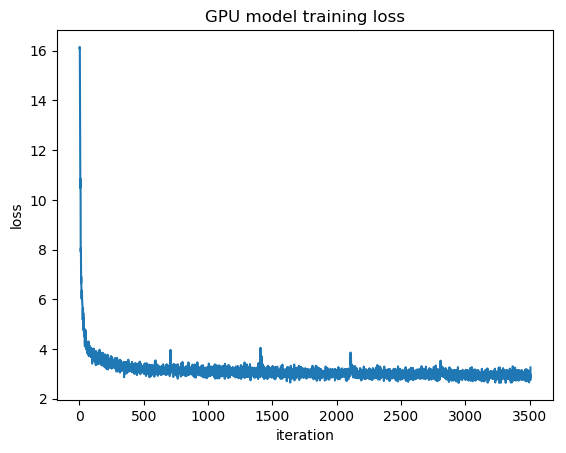

PyObject Text(24.000000000000007, 0.5, 'loss')

In [23]:
figure()
plot(get(cu_train_history, :loss)...)
title("GPU model training loss")
xlabel("iteration")
ylabel("loss")

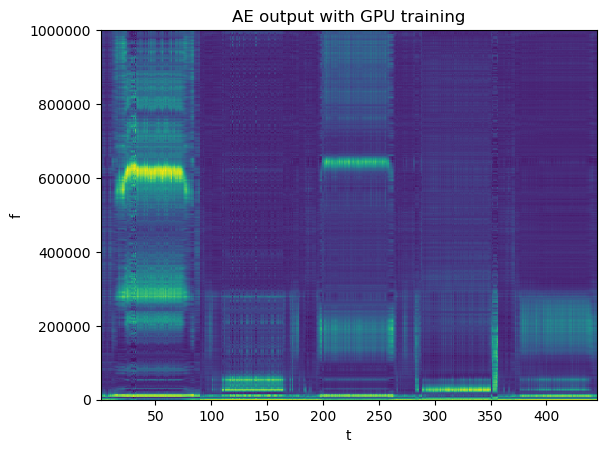

PyObject Text(24.0, 0.5, 'f')

In [24]:
figure()
X = cudata;
_X = cumodel(X).data |> cpu
pcolormesh(1:size(_X,2), f, _X)
title("VAE output with GPU training")
xlabel("t")
ylabel("f")

Check further memory allocation for GPUs

## In this part, lets try to see some sort of structure in the latent code

In [25]:
# save/load a pretrained model
f = "large_vae_model.bson"
if !isfile(f) 
    @save f large_model
else
    @load f large_model
end

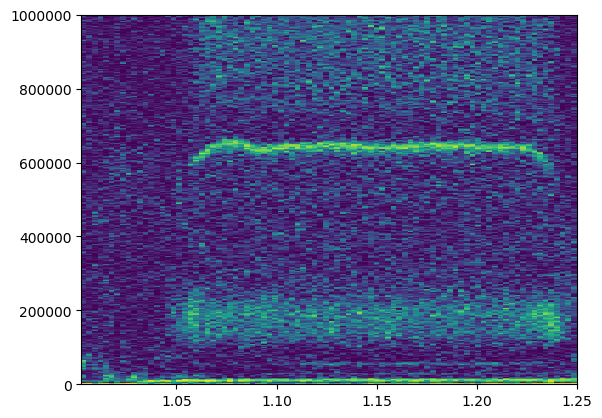

PyObject <matplotlib.collections.QuadMesh object at 0x7fc8e6c6f2b0>

In [69]:
X1, t1, f1 = get_msc_array(datapath, 11096, 11)
pcolormesh(t1, f1, X1)

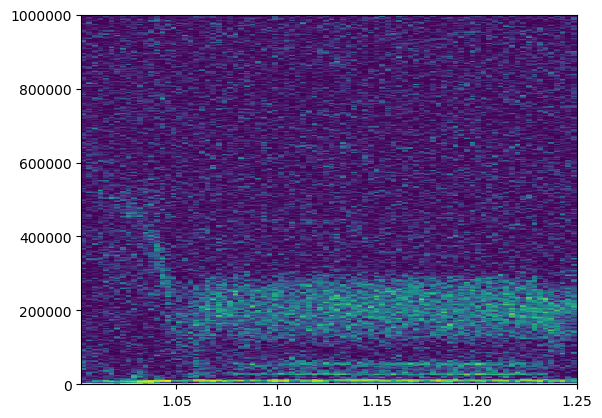

PyObject <matplotlib.collections.QuadMesh object at 0x7fc8f8256c18>

In [70]:
X0, t0, f0 = get_msc_array(datapath, 11096, 20)
pcolormesh(t0, f0, X0)

In [71]:
Xα = X1[:,1.06.<=t1.<=1.22]
zα = large_model.encoder(Xα).data
z1 = large_model.encoder(X1).data
z0 = large_model.encoder(X0).data

4×89 Array{Float32,2}:
 -0.455977   -0.37496   -0.337604   …  -0.276792   -0.207467     -0.235216
  0.323356    0.350521   0.327358       0.0594718   0.000605822   0.11486 
 -1.08288    -1.27385   -1.20294       -1.27112    -1.20864      -1.31673 
  0.0729361   0.015358   0.0903217      0.266508    0.260881      0.182985

Clearly the code is not very N(0,1) since we have used a very low $\beta$.

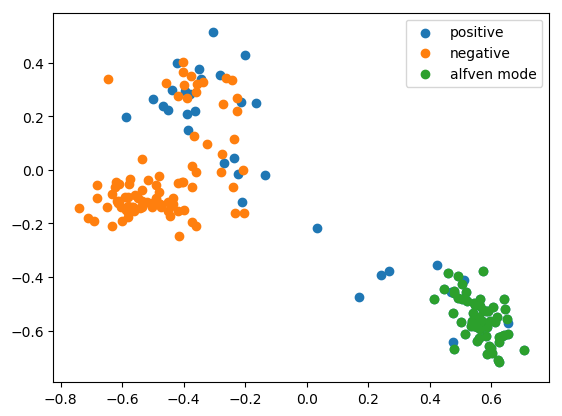

PyObject <matplotlib.legend.Legend object at 0x7fc8f83fe2e8>

In [72]:
figure()
scatter(z1[1,:], z1[2,:], label = "positive")
scatter(z0[1,:], z0[2,:], label = "negative")
scatter(zα[1,:], zα[2,:], label = "alfven mode")
legend()

Now lets "generate" a new diagram.

In [73]:
function connect(zs, l)
    L = length(zs)
    return vcat([hcat(
    collect(range(zs[i][1], zs[i+1][1]; length = l)), 
    collect(range(zs[i][2], zs[i+1][2]; length = l))
        )
    for i in 1:L-1]...)
end
zs = [[-1,-3.5], [0,-4.5], [1,-4.5], [2,-2], [0,0]]
zpath = Array(connect(zs, 50)');

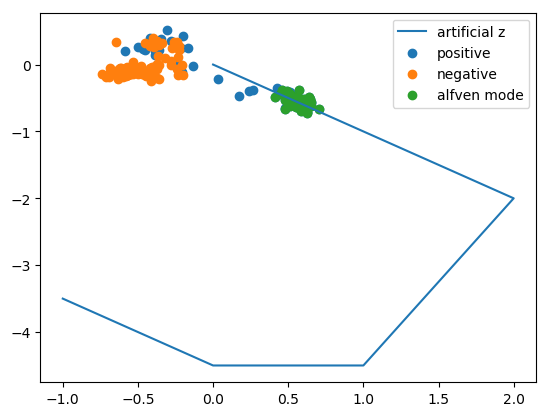

PyObject <matplotlib.legend.Legend object at 0x7fc8f8259f98>

In [74]:
figure()
scatter(z1[1,:], z1[2,:], label = "positive")
scatter(z0[1,:], z0[2,:], label = "negative")
scatter(zα[1,:], zα[2,:], label = "alfven mode")
plot(zpath[1,:], zpath[2,:], label = "artificial z")
legend()

In [75]:
Xgen = large_model.decoder(zpath).data;

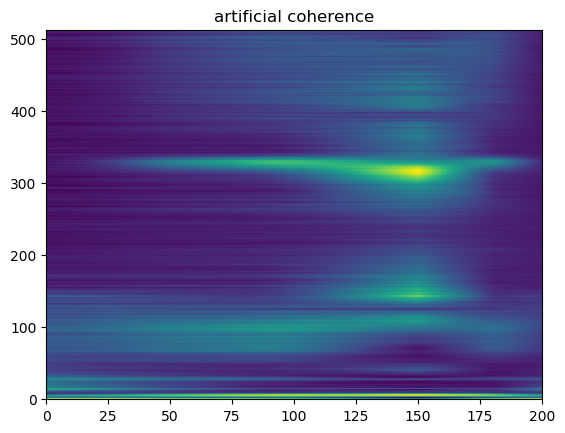

PyObject Text(0.5, 1.0, 'artificial coherence')

In [76]:
figure()
pcolormesh(Xgen)
title("artificial coherence")

In [77]:
# also, lets try to sample from N(0,1) and give it to the decoder
Xgen2 = AlfvenDetectors.sample(large_model, 100).data;

This is not a good results since only some strange phenomena were actually encoded to N(0,1), like the ends/beginnings of the shot.

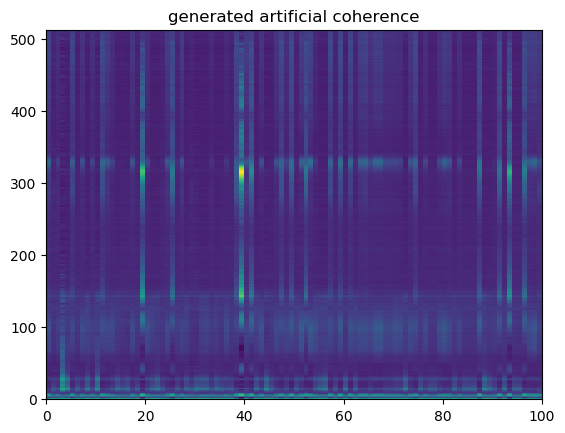

In [78]:
figure()
pcolormesh(Xgen2)
title("generated artificial coherence");

In [ ]:
show()

## Also train a diag version of VAE

In [23]:
diag_model = AlfvenDetectors.VAE([M, 200, zdim*2], [zdim, 200, M*2],variant = :diag)
diag_train_history = MVHistory()

MVHistory{History}

In [24]:
@info "Training large CPU model with diagonal covariance"

# precompilation run
@time AlfvenDetectors.fit!(diag_model, data, batchsize, 1;
    L = L, β = 1.0,
    cbit = cbit, history = diag_train_history, verb = verb)

@time AlfvenDetectors.fit!(diag_model, data, batchsize, 100;
    L = L, β = 1.0,
    cbit = cbit, history = diag_train_history, verb = verb)

┌ Info: Training large CPU model with diagonal covariance
└ @ Main In[24]:1


 11.366746 seconds (25.35 M allocations: 1.359 GiB, 7.83% gc time)
 21.979109 seconds (2.75 M allocations: 9.067 GiB, 8.02% gc time)


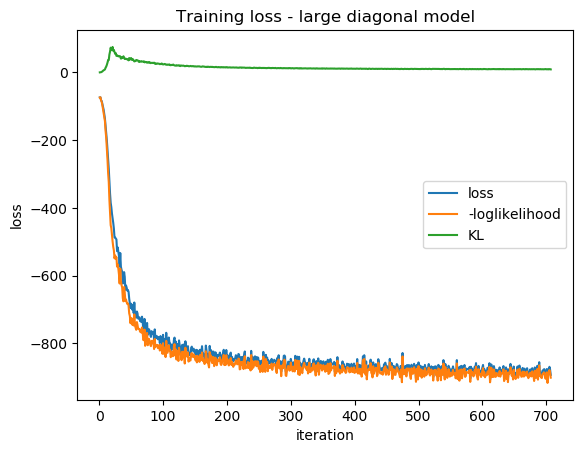

PyObject <matplotlib.legend.Legend object at 0x7fc8e6b54b38>

In [119]:
figure()
plot(get(diag_train_history, :loss)..., label="loss")
plot(get(diag_train_history, :loglikelihood)..., label="-loglikelihood")
plot(get(diag_train_history, :KL)..., label="KL")
title("Training loss - large diagonal model")
xlabel("iteration")
ylabel("loss")
legend()

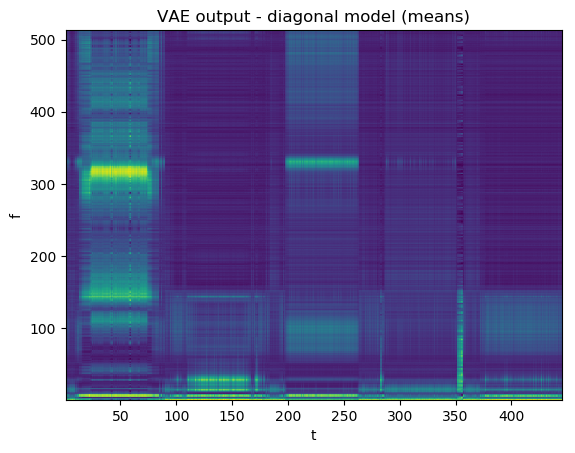

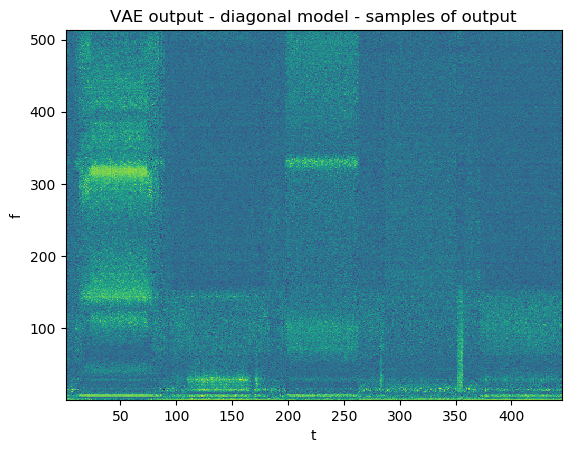

PyObject Text(24.000000000000007, 0.5, 'f')

In [123]:
figure()
dlX = diag_model(X).data
pcolormesh(1:size(dlX,2), collect(1:M), dlX[1:M,:])
title("VAE output - diagonal model (means)")
xlabel("t")
ylabel("f")

# before we ahve only taken the means, now sample from the posterior properly
sdlX = AlfvenDetectors.samplenormal(dlX)
figure()
pcolormesh(1:size(sdlX,2), collect(1:M), sdlX)
title("VAE output - diagonal model - samples of output")
xlabel("t")
ylabel("f")


In [112]:
# save/load a pretrained model
f = "diag_vae_model.bson"
if !isfile(f) 
    @save f diag_model
else
    @load f diag_model
end

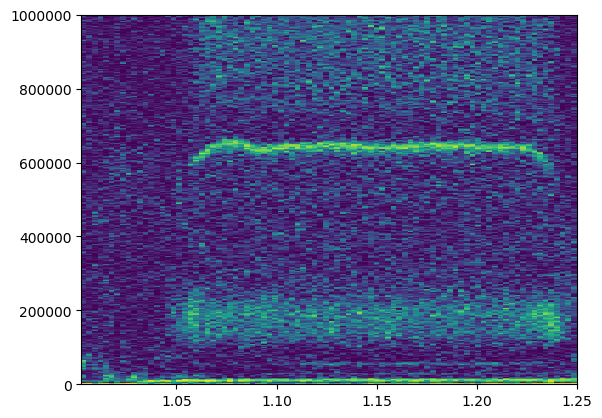

PyObject <matplotlib.collections.QuadMesh object at 0x7fc8e677cda0>

In [124]:
X1, t1, f1 = get_msc_array(datapath, 11096, 11)
pcolormesh(t1, f1, X1)

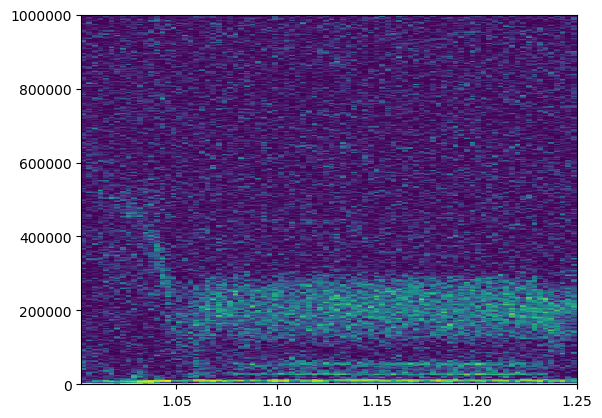

PyObject <matplotlib.collections.QuadMesh object at 0x7fc8e66d1b70>

In [125]:
X0, t0, f0 = get_msc_array(datapath, 11096, 20)
pcolormesh(t0, f0, X0)

In [126]:
Xα = X1[:,1.06.<=t1.<=1.22]
zα = diag_model.encoder(Xα).data
z1 = diag_model.encoder(X1).data
z0 = diag_model.encoder(X0).data

4×89 Array{Float32,2}:
 -1.83408  -2.24182  -2.15585  -2.23357  …  -2.05626  -2.06002  -1.9833 
 -1.86453  -1.38433  -1.24666  -1.18519     -1.8205   -1.71292  -1.60456
 -4.84878  -4.64881  -4.65407  -4.72497     -5.66438  -5.81989  -5.4996 
 -4.07396  -4.02927  -4.00844  -4.19503     -4.86092  -5.33031  -5.1851 

The code does not seem to be very N(0,1).

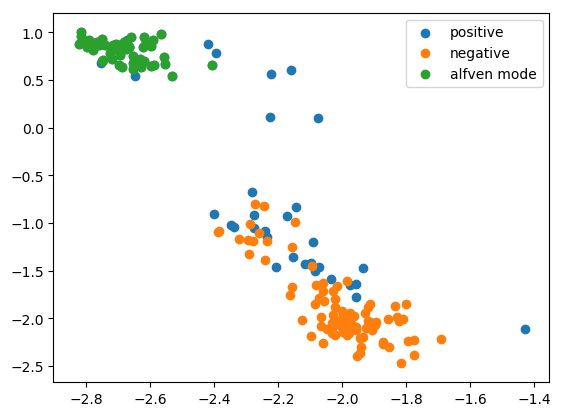

PyObject <matplotlib.legend.Legend object at 0x7fc8e6610f60>

In [128]:
figure()
scatter(z1[1,:], z1[2,:], label = "positive")
scatter(z0[1,:], z0[2,:], label = "negative")
scatter(zα[1,:], zα[2,:], label = "alfven mode")
legend()

### Takeaways

Obviously the sampling introduces noise in the places where we should see clear zeros but the structure is there. Also, artifacts are introduced in the output of the model with more training - overfitting? Also, tuning $\beta$ does not play a role now as the output variance is estimated afterwards. Training is super slow. 

Tuning or not tuning of $\beta$ does not seem to have an effect on the cluster in latent space.

## Also train a diag version of VAE with GPU

In [21]:
M,N = size(data)
zdim = 2
cudata = data |> gpu
gpu_diag_model = AlfvenDetectors.VAE([M, 200, zdim*2], [zdim, 200, M*2],variant = :diag) |> gpu
gpu_diag_train_history = MVHistory()
L = 1
verb = false
cbit = 1
batchsize = 64

64

In [22]:
@info "Training large GPU model with diagonal covariance"

# precompilation run
@time AlfvenDetectors.fit!(gpu_diag_model, cudata, batchsize, 1;
    L = L, β = 0.01,
    cbit = cbit, history = gpu_diag_train_history, verb = verb)

@time AlfvenDetectors.fit!(gpu_diag_model, cudata, batchsize, 100;
    L = L, β = 0.01,
    cbit = cbit, history = gpu_diag_train_history, verb = verb)

┌ Info: Training large GPU model with diagonal covariance
└ @ Main In[22]:1


  7.297670 seconds (15.41 M allocations: 805.095 MiB, 6.64% gc time)
 12.668685 seconds (10.63 M allocations: 707.838 MiB, 1.82% gc time)


Here GPU is actually very very fast by at least an order of magnitude.